In [1]:
import sys, os, time
import shutil
# %load_ext autoreload
# %autoreload 2
os.environ['FOUNDATION_RUN_MODE'] = 'jupyter'
os.environ['FOUNDATION_SAVE_DIR'] = '/is/ei/fleeb/workspace/chome/trained_nets'
os.environ['FOUNDATION_DATA_DIR'] = '/is/ei/fleeb/workspace/local_data'
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
from IPython import display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
import torchvision.models
import torchvision

from torch.utils.data import Dataset, DataLoader, TensorDataset
import gym
import numpy as np
%matplotlib notebook
# %matplotlib tk
import matplotlib.pyplot as plt
import imageio
import seaborn as sns
# plt.switch_backend('Agg') #('Qt5Agg')
import foundation as fd
from foundation import models
from foundation import util
from foundation import train

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from bisect import bisect_left

# from IPython.display import HTML, Image

#from foundation.util import replicate, Cloner

from hybrid import get_model, get_data
from analyze import *

from tqdm import tqdm_notebook as tqdm

# plt.ioff()

np.set_printoptions(linewidth=120, suppress=True)

In [2]:
# dataset = train.get_dataset('nocap-3dshapes', dataroot=os.environ['FOUNDATION_DATA_DIR'], negative=True)
# len(dataset)

In [3]:
# dataset = train.get_dataset('transfer', new='nocap-3dshapes', budget=100,
#                             new_kwargs={'dataroot':os.environ['FOUNDATION_DATA_DIR'], 'labels':False})
# len(dataset)

In [34]:
# dataset = train.get_dataset('byfactor', dataroot=os.environ['FOUNDATION_DATA_DIR'], labels=False,
#                            factor='shape', counts=[0,10,0,10])

dataset = train.get_dataset('byfactor', dataroot=os.environ['FOUNDATION_DATA_DIR'], labels=False,
                           factor='shape', counts=[0, None, 0, 0])

len(dataset)

Filtering out 287979/384000 samples


96021

In [23]:
i = 0

16653


<IPython.core.display.Javascript object>


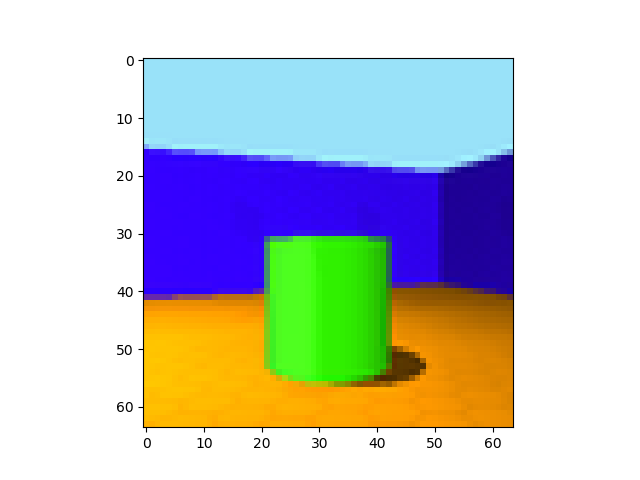

In [36]:
# i += 1
i = np.random.randint(len(dataset))
print(i)
sample = dataset[i]
if len(sample) > 1:
    x,y = dataset[i]
    print(y)
else:
    x, = dataset[i]
plt.imshow(x.permute(1,2,0).numpy())

In [5]:
args = parse_args(['--split','all','--model','3dshapes-dvae_0100-5966131-07_200109-133026/'])
args

Namespace(batch_size=50, model='3dshapes-dvae_0100-5966131-07_200109-133026/', n_samples=50000, save_path=None, save_stat=False, seed=10, split='all')

In [ ]:
batch_size = args.batch_size
block_idx = utils.InceptionV3.BLOCK_INDEX_BY_DIM[2048]
n_samples = args.n_samples

In [6]:
path = args.model
_args, model = train.load(path=path, A=None, get_model=get_model, get_data = None, return_args = True)
dataset = _args.dataset.name
model.eval().to(_args.device)

/is/ei/fleeb/workspace/chome/trained_nets/3dshapes-dvae_0100-5966131-07_200109-133026/best.pth.tar
True
load successful
Loaded /is/ei/fleeb/workspace/chome/trained_nets/3dshapes-dvae_0100-5966131-07_200109-133026/best.pth.tar
Set dataroot to: /is/ei/fleeb/workspace/local_data
Model-type: dvae
prob: 1
prob_max: None (by default)
encoder (type=double-enc): 
  latent_dim: 8
  min_log_std: None (by default)
  in_shape --> din: [3, 64, 64] (by parent)
  channels: [64, 64, 64, 128, 128] (by parent)
  factors: 2 (by parent)
  internal_channels: [None, None, None, None, None] (by default)
  squeeze: [False, False, False, False, False] (by default)
  output_nonlin: None (by default)
  latent_dim: 16
  tail (type=nn): 
    input_dim --> din: (128, 2, 2)
    output_dim --> dout: 16
    hidden_dims: [256, 128]
    nonlin: elu (by parent)
    output_nonlin: None (by default)
  nonlin: elu (by parent)
  output_nonlin: None (by default)
  output_norm_type: None (by default)
  down_type: max (by paren

/is/ei/fleeb/workspace/foundation/foundation/train/config.py:66: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f)


Moving model to cuda
Model on cuda
Loaded model_state from checkpoint


In [ ]:
model_inception = utils.InceptionV3([block_idx]).to(_args.device).eval()

In [10]:
filename = '3dshapes_stats_fid_train.pkl'
dataroot = os.path.join(os.environ['FOUNDATION_DATA_DIR'], '3dshapes')

In [12]:
path = os.path.join(dataroot, filename)
os.path.isfile(path), path

(True,
 '/is/ei/fleeb/workspace/local_data/3dshapes/3dshapes_stats_fid_train.pkl')

In [14]:
util.count_parameters(model_inception)

21785568

In [ ]:
pred_arr = np.empty((n_samples, 2048))
out = {}
if stat_ref:
    if dataset == '3dshapes':
        data = datasets.Shapes3D(dataroot = os.environ['FOUNDATION_DATA_DIR'], train = mode, labels = True)
    else:
        raise NotImplementedError
    assert len(data) >= n_samples, 'Number of samples should be less than dataset size'
    indices = np.random.randint(0, len(data), n_samples)

j = 0
print('Computing Inception Features')
while j < n_samples:
    if j% (batch_size*100) == 0:
        print('Done', j , 'Samples')
    curr_batch_size = min(batch_size, n_samples - j)
    with torch.no_grad():
        if stat_ref:
            generated, _ = data[indices[j:j+curr_batch_size]]
            generated = generated.to(model.device)
        else:
            if hybrid:
                q = model.sample_prior(curr_batch_size)
                generated = model.decode(util.shuffle_dim(q))
            else:
                generated = model.generate(curr_batch_size)

        pred = model_inception(generated)[0]
        if pred.shape[2] != 1 or pred.shape[3] != 1:
            pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

        pred_arr[j:j+curr_batch_size] = pred.cpu().data.numpy().reshape(curr_batch_size, -1)

    j += curr_batch_size
m = np.mean(pred_arr, axis=0)
s = np.cov(pred_arr, rowvar=False)
if save_stats is not None:
    out['indices'] = indices
    out['m'] = m
    out['sigma'] = s
    with open(save_stats,'wb') as b:
        pkl.dump(out, b)